# Image Colorization with Autoencoders

## Import Libraries

In [14]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

## Colorization Autoencoder

In [15]:
class ColorizationAutoencoder(nn.Module):
    def __init__(self,
                 hidden_channels=[],
                 kernel_size=3,
                 stride=2,
                 act_fn=nn.ReLU(True)
    ):
        """
        Initialize Colorization Autoencoder.
        Args:
            hidden_channels (list): List of hidden channels for each layer in the encoder.
            act_fn (nn.Module): Activation function to use in the network.
            kernel_size (int): size of kernel
            stride (int): stride of the CNN layers in encoder and decoder.
            Note: List of hidden channels in the decoder is reversed from hidden_channels.
        """
        super(ColorizationAutoencoder, self).__init__()
        len_hc = len(hidden_channels)

        # Encoder
        encoder_layers = [
            nn.Conv2d(1, hidden_channels[0], kernel_size=kernel_size,
                stride=stride, padding=1),
            act_fn]
        for i in range(1, len_hc):
            encoder_layers.append(nn.Conv2d(hidden_channels[i-1], hidden_channels[i],
                kernel_size=kernel_size, stride=stride, padding=1))
            encoder_layers.append(act_fn)
        self.encoder = nn.Sequential(*encoder_layers)

        # Decoder
        # ConvTranspose with stride > 1 is used for upsampling the image
        decoder_layers = []
        for i in range(len_hc-1, 0, -1):
            decoder_layers.append(nn.ConvTranspose2d(hidden_channels[i], hidden_channels[i-1],
                kernel_size=kernel_size, stride=stride, padding=1, output_padding=1))
            decoder_layers.append(act_fn)
        decoder_layers.append(nn.ConvTranspose2d(hidden_channels[0], 3,
            kernel_size=kernel_size, stride=2, padding=1, output_padding=1))
        decoder_layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*decoder_layers)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [16]:
class ImageDataset(Dataset):
    def __init__(self, train=True):
        # Compose is used to chain multiple preprocessing steps.
        transformer = transforms.Compose([
            transforms.ToTensor() # Convert PIL Image to Tensor [0, 1]
        ])
        self.data = datasets.CIFAR10(root='./data', train=train, download=True,
            transform=transformer)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        rgb_img, _ = self.data[idx]
        # Convert RGB to grayscale using luminosity method
        gray_img = 0.299*rgb_img[0] + 0.587*rgb_img[1] + 0.114*rgb_img[2]
        gray_img = gray_img.unsqueeze(0)
        return rgb_img, gray_img

In [17]:
def train(model, optimizer, criterion, train_loader, test_loader, num_epochs, device):
    model.train()
    train_loss_lst = []
    eval_loss_lst = []
    for epoch in range(num_epochs):
        train_loss = 0
        print(f"Epoch [{epoch+1}/{num_epochs}]: ")
        for rgb_img, gray_img in train_loader:
            rgb_img, gray_img = rgb_img.to(device), gray_img.to(device)
            # Forward pass
            output = model(gray_img)
            loss = criterion(output, rgb_img)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        train_loss = train_loss / len(train_loader)
        print(f"Training Loss: {train_loss:.4f}")
        eval_loss = evaluate(model, criterion, test_loader, device)
        train_loss_lst.append(train_loss)
        eval_loss_lst.append(eval_loss)
    return train_loss_lst, eval_loss_lst

def evaluate(model, criterion, test_loader, device) -> float:
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for rgb_img, gray_img in test_loader:
            rgb_img, gray_img = rgb_img.to(device), gray_img.to(device)
            # Forward pass
            output = model(gray_img)
            loss = criterion(output, rgb_img)

            eval_loss += loss.item()
    eval_loss = eval_loss / len(test_loader)
    print(f"Testing Loss: {eval_loss:.4f}")
    return eval_loss

## Parameters

In [18]:
hidden_channels = [64, 128, 256]
learning_rate = 1e-3
NUM_EPOCHS = 30

## Main

In [19]:
train_dataset = ImageDataset(train=True)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = ImageDataset(train=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ColorizationAutoencoder(hidden_channels).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_lst, eval_loss_lst = train(model, optimizer, criterion, train_loader, test_loader, num_epochs=NUM_EPOCHS, device=device)

Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30]: 
Training Loss: 0.0127
Testing Loss: 0.0086
Epoch [2/30]: 
Training Loss: 0.0078
Testing Loss: 0.0073
Epoch [3/30]: 
Training Loss: 0.0070
Testing Loss: 0.0071
Epoch [4/30]: 
Training Loss: 0.0066
Testing Loss: 0.0066
Epoch [5/30]: 
Training Loss: 0.0064
Testing Loss: 0.0066
Epoch [6/30]: 
Training Loss: 0.0062
Testing Loss: 0.0063
Epoch [7/30]: 
Training Loss: 0.0060
Testing Loss: 0.0060
Epoch [8/30]: 
Training Loss: 0.0059
Testing Loss: 0.0060
Epoch [9/30]: 
Training Loss: 0.0058
Testing Loss: 0.0058
Epoch [10/30]: 
Training Loss: 0.0058
Testing Loss: 0.0059
Epoch [11/30]: 
Training Loss: 0.0057
Testing Loss: 0.0057
Epoch [12/30]: 
Training Loss: 0.0056
Testing Loss: 0.0062
Epoch [13/30]: 
Training Loss: 0.0056
Testing Loss: 0.0056
Epoch [14/30]: 
Training Loss: 0.0056
Testing Loss: 0.0055
Epoch [15/30]: 
Training Loss: 0.0055
Testing Loss: 0.0055
Epoch [16/30]: 
Training Loss: 0.0055
Testing Lo

## Visualization

In [27]:
def show_examples(model, data_loader, idx, device):
    model.eval()
    with torch.no_grad():
        it = iter(data_loader)
        color, gray = next(it)
        for i in range(idx):
          color, gray = next(it)

        gray, color = gray.to(device), color.to(device)
        output = model(gray)

        gray = gray.cpu().numpy()
        color = color.cpu().numpy()
        output = output.cpu().numpy()

        fig, axes = plt.subplots(3, 8, figsize=(16, 6))
        for i in range(8):
            # Display grayscale input
            axes[0, i].imshow(gray[i][0], cmap='gray')
            axes[0, i].axis('off')
            # Display predicted color output
            axes[1, i].imshow(output[i].transpose(1, 2, 0))
            axes[1, i].axis('off')
            # Display ground truth
            axes[2, i].imshow(color[i].transpose(1, 2, 0))
            axes[2, i].axis('off')

        axes[0, 0].set_title("Grayscale Input")
        axes[1, 0].set_title("Predicted Color")
        axes[2, 0].set_title("Ground Truth")
        plt.tight_layout()
        plt.show()

def plot_losses(train_loss_lst, eval_loss_lst):
    # Plot training and evaluation losses
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_loss_lst) + 1), train_loss_lst, label='Training Loss', marker='o')
    plt.plot(range(1, len(eval_loss_lst) + 1), eval_loss_lst, label='Validation Loss', marker='x')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.xticks(range(1, len(train_loss_lst) + 1))
    plt.tight_layout()
    plt.show()

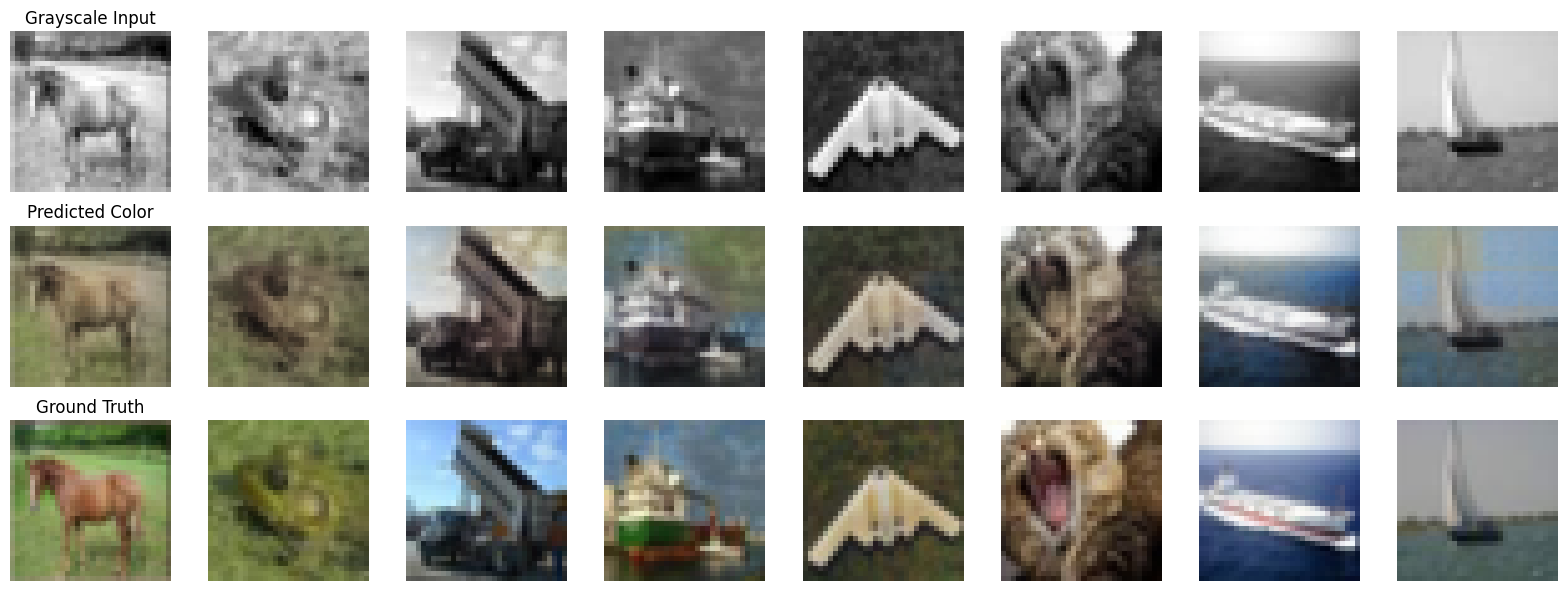

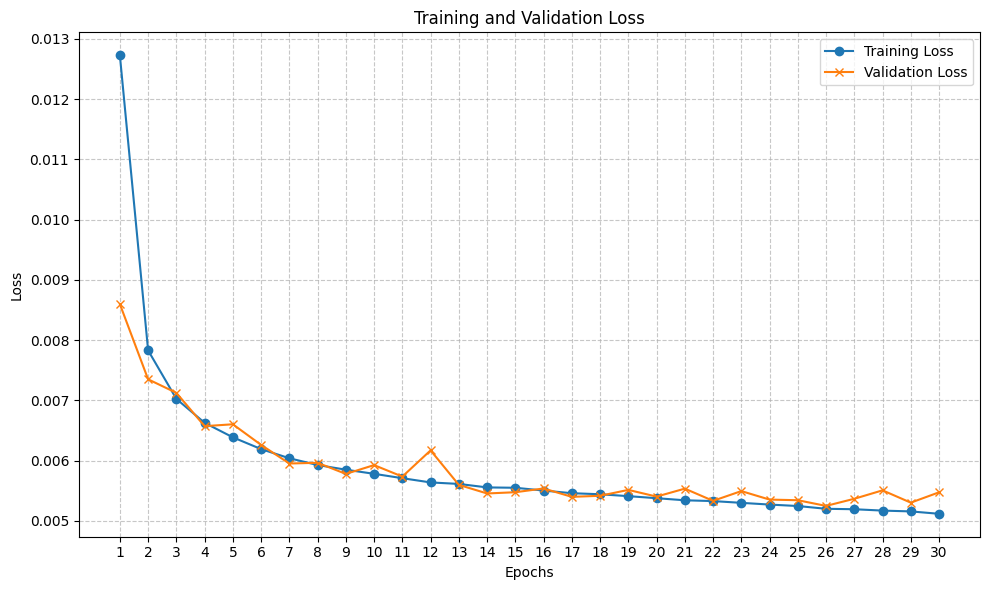

In [32]:
show_examples(model, test_loader, 6, device)
plot_losses(train_loss_lst, eval_loss_lst)